<h1 style="font-family:Impact,Arial;font-size:30px;">37004 Interest Rates and Credit Risk Models - Spring 2024</h1>
<h1 style="font-family:Impact,Arial;font-size:45px;">Assignment Part 1</h1>
<h2 style="font-family:Arial;">Erik Schl&ouml;gl</h2>
<p><small> School of Mathematical &amp; Physical Sciences<br>
University of Technology Sydney
</small></p>
<p>
<a href="mailto:Erik.Schlogl@uts.edu.au?Subject=37000 JIT" target="_blank">
<small><font color=MediumVioletRed>Erik.Schlogl@uts.edu.au</font></small></a>
</p>
<hr style="height:5px;border:none;color:#333;background-color:#333;" />


In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import fsolve as solver
import matplotlib.pyplot as plt

In [2]:
df = pd.DataFrame(
    [
        {"Type": "BBSW", "Term": "1 month", "Rate": 4.06},
        {"Type": "BBSW", "Term": "3 months", "Rate": 4.17},
        {"Type": "BBSW", "Term": "6 months", "Rate": 4.50},
        {"Type": "Swap", "Term": "1 year", "Rate": 4.29},
        {"Type": "Swap", "Term": "3 years", "Rate": 4.06},
        {"Type": "Swap", "Term": "5 years", "Rate": 4.20},
        {"Type": "Swap", "Term": "10 years", "Rate": 4.45},
        {"Type": "Swap", "Term": "15 years", "Rate": 4.58},
    ]
)
df

,Type,Term,Rate
0,BBSW,1 month,4.06
1,BBSW,3 months,4.17
2,BBSW,6 months,4.50
3,Swap,1 year,4.29
4,Swap,3 years,4.06
5,Swap,5 years,4.20
6,Swap,10 years,4.45
7,Swap,15 years,4.58


Note that the bank bill swap rate (BBSW) is quoted per annum with simple compounding, and "Swaps are quoted on a quarterly basis for maturities out to 3 years and on a semi-annual basis for maturities 4 years and greater." AFMA (2023), Interest Rate Derivative Conventions (see https://afma.com.au/getattachment/Standards/Market-Conventions/Sections/Content/Interest-Rate-Derivative-Conventions-2023-07.pdf?lang=en-AU )


<H2>Task 1:</H2>
Determine the term structure of zero coupon bond prices that these rates imply, using loglinear interpolation where necessary. <I>(4 marks)</I>


In [3]:
def term_structure_constructor(df):
    new_df = pd.DataFrame(df)
    new_df["Term"] = [1 / 12, 1 / 4, 1 / 2, 1, 3, 5, 10, 15]
    new_df["Rate"] = new_df["Rate"] / 100
    term_structure = pd.DataFrame(
        {
            "Term": [0] + list(new_df["Term"]),
            "Discount Factor": [1] + [np.nan for _ in range(len(new_df))],
        }
    )

    def loglin_interpolate(t, B=None):
        if t in term_structure["Term"].array:
            df = (
                term_structure[term_structure["Term"] == t]
                .reset_index(drop=True)
                .iloc[0, 1]
            )
            if np.isnan(df):
                if B == None:
                    return ValueError("B2 must be entered")
                else:
                    return B
            else:
                return df
        T1 = term_structure[term_structure["Term"] < t]["Term"].max()
        T2 = term_structure[term_structure["Term"] > t]["Term"].min()
        B1 = (
            term_structure[term_structure["Term"] == T1]
            .reset_index(drop=True)
            .iloc[0, 1]
        )
        B2 = (
            term_structure[term_structure["Term"] == T2]
            .reset_index(drop=True)
            .iloc[0, 1]
        )
        if np.isnan(B2):
            if B == None:
                return ValueError("B2 must be entered")
            else:
                B2 = B
        return B1 * ((B2 / B1) ** ((t - T1) / (T2 - T1)))

    # BBSW part
    BBSW = new_df[new_df["Type"] == "BBSW"].reset_index(drop=True)
    for i in range(len(BBSW)):
        term_structure.iloc[i + 1, 1] = 1 / (1 + BBSW.iloc[i, 1] * BBSW.iloc[i, 2])

    # Swap part
    Swap = new_df[new_df["Type"] == "Swap"].reset_index(drop=True)

    def swap_rate_to_df(x, rate, freq, T):
        payments = np.arange(freq, T + freq, freq)
        dfs = []
        for t in payments:
            dfs.append(loglin_interpolate(t, x[0]))
        return [(1 - dfs[-1]) - rate * freq * np.sum(dfs)]

    for i in range(len(Swap)):
        T = Swap.iloc[i, 1]
        rate = Swap.iloc[i, 2]
        freq = 1 / 4 if T <= 3 else 1 / 2
        term_structure.iloc[i + 1 + len(BBSW), 1] = solver(
            swap_rate_to_df, [0.2], (rate, freq, T)
        )[0]

    def df_calculator(t):
        if t < 0 or t > 15:
            return ValueError("t must be in range [0,15]")
        if t in term_structure["Term"].array:
            df = (
                term_structure[term_structure["Term"] == t]
                .reset_index(drop=True)
                .iloc[0, 1]
            )
            return df
        T1 = term_structure[term_structure["Term"] < t]["Term"].max()
        T2 = term_structure[term_structure["Term"] > t]["Term"].min()
        B1 = (
            term_structure[term_structure["Term"] == T1]
            .reset_index(drop=True)
            .iloc[0, 1]
        )
        B2 = (
            term_structure[term_structure["Term"] == T2]
            .reset_index(drop=True)
            .iloc[0, 1]
        )
        return B1 * ((B2 / B1) ** ((t - T1) / (T2 - T1)))

    return df_calculator, term_structure

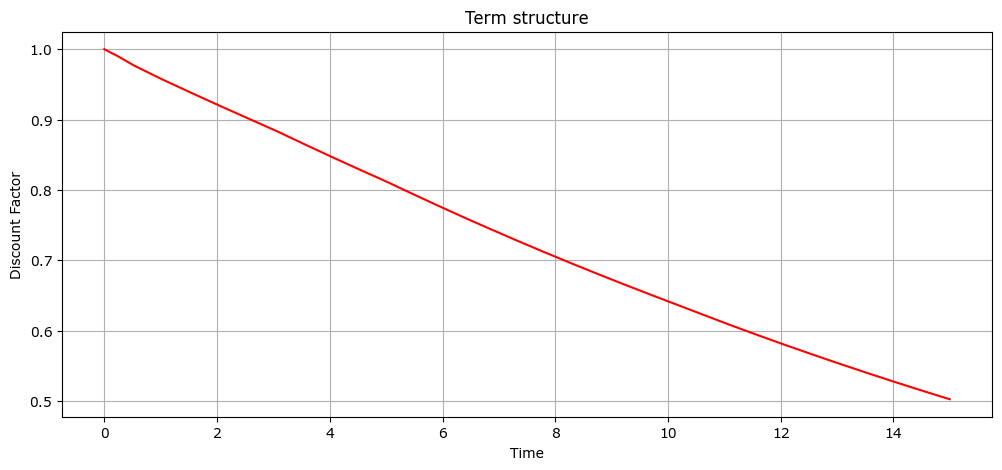

Term structure is define by the given zero counpon bonds price below:
        Term  Discount Factor
0   0.000000         1.000000
1   0.083333         0.996628
2   0.250000         0.989683
3   0.500000         0.977995
4   1.000000         0.958237
5   3.000000         0.886004
6   5.000000         0.812171
7  10.000000         0.641859
8  15.000000         0.502594
Any discount factor at the time in range [0,15] will be calculated via log-linear interpolation of the 2 closest zero counpon bonds on both side of the time in the above table


In [4]:
df_calculator_1, term_structure = term_structure_constructor(df)
t = np.arange(0, 15, 1 / 500)
dfs = list(map(lambda x: df_calculator_1(x), t))
plt.figure(figsize=(12, 5))
plt.plot(t, dfs, linestyle="-", color="r")
plt.title("Term structure")
plt.xlabel("Time")
plt.ylabel("Discount Factor")
plt.grid(True)
plt.show()
print("Term structure is define by the given zero counpon bonds price below:")
print(term_structure)
print(
    "Any discount factor at the time in range [0,15] will be calculated via log-linear interpolation of the 2 closest zero counpon bonds on both side of the time in the above table"
)

<H2>Task 2:</H2>
Find the coefficients of a "maximum smoothness" term structure (as defined on Slides 34 to 36 of Lecture 1b) fitting the BBSW and swap rates given above. <I>(10 marks)</I>


In [5]:
def smoothness_constructor(df, term_structure):
    new_df = pd.DataFrame(df)
    new_df["Term"] = [1 / 12, 1 / 4, 1 / 2, 1, 3, 5, 10, 15]
    new_df["Rate"] = new_df["Rate"] / 100
    points = len(new_df)
    BBSW = new_df[new_df["Type"] == "BBSW"].reset_index(drop=True)
    Swap = new_df[new_df["Type"] == "Swap"].reset_index(drop=True)

    def solve(p):
        results = []
        a = p[:points]
        b = p[points : 2 * points]
        c = p[2 * points :]

        # Condition 1
        for i in range(points - 1):
            t = new_df.iloc[i, 1]
            results.append(
                (c[i] * (t**4) + b[i] * t + a[i])
                - (c[i + 1] * (t**4) + b[i + 1] * t + a[i + 1])
            )

        # Condition 2
        for i in range(points - 1):
            t = new_df.iloc[i, 1]
            results.append(
                (4 * c[i] * (t**3) + b[i]) - (4 * c[i + 1] * (t**3) + b[i + 1])
            )

        # Condition 3
        results.append(b[-1])
        results.append(a[0] - new_df.iloc[0, 2])

        # Condition 4
        for i in range(len(BBSW)):
            ti = BBSW.iloc[i, 1]
            t = BBSW.iloc[i - 1, 1] if i != 0 else 0
            results.append(
                (1 / 5) * c[i] * ((ti**5) - (t**5))
                + (1 / 2) * b[i] * ((ti**2) - (t**2))
                + a[i] * (ti - t)
                + np.log(term_structure.iloc[i + 1, 1] / term_structure.iloc[i, 1])
            )

        def inside_instant_calculator(t):
            T = list(new_df["Term"])
            ts = [0] + list(filter(lambda x: x < t, T)) + [t]
            sum = 0
            for i in range(len(ts) - 1):
                sum += (
                    (1 / 5) * c[i] * (ts[i + 1] ** 5 - ts[i] ** 5)
                    + (1 / 2) * b[i] * (ts[i + 1] ** 2 - ts[i] ** 2)
                    + a[i] * (ts[i + 1] - ts[i])
                )
            return sum

        for i in range(len(Swap)):
            t = Swap.iloc[i, 1]
            freq = 1 / 4 if t <= 3 else 1 / 2
            payments = np.arange(freq, t, freq)
            l = Swap.iloc[i, 2] * freq
            sum_dfs = sum(
                list(map(lambda x: np.exp(-inside_instant_calculator(x)), payments))
            )
            results.append(
                inside_instant_calculator(t) + np.log((1 - l * sum_dfs) / (1 + l))
            )

        return results

    p = solver(solve, [100] * len(new_df) * 3)
    a = p[:points]
    b = p[points : 2 * points]
    c = p[2 * points :]
    T = list(new_df["Term"])

    def spline(t):
        i = len(list(filter(lambda x: x < t, T)))
        return c[i] * (t**4) + b[i] * t + a[i]

    def df_calculator(t):
        ts = [0] + list(filter(lambda x: x < t, T)) + [t]
        sum = 0
        for i in range(len(ts) - 1):
            sum += (
                (1 / 5) * c[i] * (ts[i + 1] ** 5 - ts[i] ** 5)
                + (1 / 2) * b[i] * (ts[i + 1] ** 2 - ts[i] ** 2)
                + a[i] * (ts[i + 1] - ts[i])
            )
        return np.exp(-sum)

    return spline, df_calculator

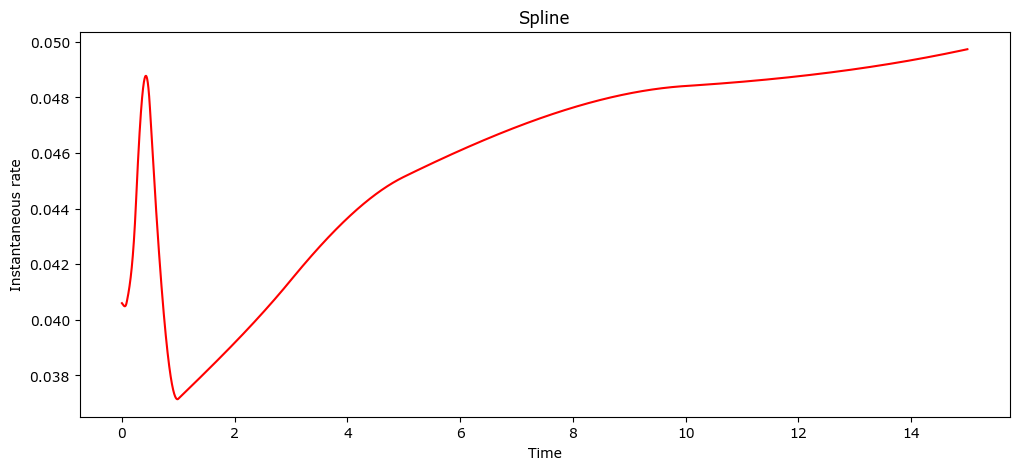

In [6]:
spline, df_calculator_2 = smoothness_constructor(df, term_structure)
t = np.arange(0, 15, 1 / 1000)
inst_rate = list(map(lambda x: spline(x), t))
plt.figure(figsize=(12, 5))
plt.plot(t, inst_rate, linestyle="-", color="r", label="Instantaneous Rate")
plt.title("Spline")
plt.xlabel("Time")
plt.ylabel("Instantaneous rate")
plt.show()

<H2>Task 3:</H2>
Consider a coupon bond with a principal of 100 and a coupon rate of 8% per annum, where the bond matures in exactly five years and the coupons are paid quarterly. Using the term structure that you derived in Task 1, what is the value of this bond? Similarly, using the term structure that you derived in Task 2, what is the value of this bond? <I>(1 mark)</I>


In [7]:
def bond_value_calc(F, c, freq, T):
    payments = np.arange(freq, freq + T, freq)
    B1 = list(map(lambda x: df_calculator_1(x), payments))
    B2 = list(map(lambda x: df_calculator_2(x), payments))
    return (
        np.sum(np.array(B1)) * c * freq * F + B1[-1] * F,
        np.sum(np.array(B2)) * c * freq * F + B2[-1] * F,
    )

In [8]:
value_1, value_2 = bond_value_calc(100, 0.08, 1 / 4, 5)
print("Value under Task 1 structure: ", value_1)
print("Value under Task 2 structure: ", value_2)

Value under Task 1 structure:  117.18242749767916
Value under Task 2 structure:  117.18980599957408
